In [ ]:
import pandas as pd
from openai import OpenAI
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

client = OpenAI(api_key = "")

df = pd.read_csv("final_df.csv")
df = df.sample(500, random_state=42).reset_index(drop=True)
df.to_csv("500_patients.csv", index=False)

df["mortality"].sum()

def llm_predict(prompt):
    completion = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    content = completion.choices[0].message.content.lower()
    return 1 if "yes" in content else 0


In [12]:
# Baseline

def patient_to_raw_prompt(row):
    parts = []
    for col, val in row.items():
        if col in ("Id", "mortality"):
            continue
        parts.append(f"{col}={val}")
    body = ", ".join(parts)
    return (
        f"Patient record: {body}. "
        "Predict whether the patient will die. Answer yes or no."
    )


preds_raw = []
for _, row in df.iterrows():
    prompt = patient_to_raw_prompt(row)
    pred = llm_predict(prompt)
    preds_raw.append(pred)

df["pred_raw"] = preds_raw

y_true = df["mortality"].values
y_pred = df["pred_raw"].values

print("\n===== BASELINE RESULTS (Raw Structured → GPT) =====")
print("F1:", f1_score(y_true, y_pred))
print("AUROC:", roc_auc_score(y_true, y_pred))
print("AUPRC:", average_precision_score(y_true, y_pred))



===== BASELINE RESULTS (Raw Structured → GPT) =====
F1: 0.25263157894736843
AUROC: 0.5713238374528697
AUPRC: 0.18323510971786833


In [16]:
# Natural-language descriptions

def patient_to_narrative(row):
    # Gender text
    gender = "male" if row["is_male"] == 1 else "female"

    # Chronic condition list
    conditions = []
    if row["diabetes"]: conditions.append("diabetes")
    if row["hypertension"]: conditions.append("hypertension")
    if row["hyperlipidemia"]: conditions.append("high cholesterol")
    if row["obesity"]: conditions.append("obesity")
    if row["cancer"]: conditions.append("cancer")
    if row["heart_failure"]: conditions.append("heart failure")

    condition_text = (
        ", ".join(conditions)
        if len(conditions) > 0 else
        "no major chronic diseases"
    )

    # Medications
    meds = []
    if row["insulin"]: meds.append("insulin")
    if row["metformin"]: meds.append("metformin")
    if row["statin"]: meds.append("statins")
    if row["ace_inhibitor"]: meds.append("an ACE inhibitor")
    if row["anticoagulant"]: meds.append("an anticoagulant")

    med_text = (
        ", ".join(meds)
        if len(meds) > 0 else
        "no chronic medications"
    )

    # Build narrative
    text = (
        f"The patient is a {row['age']}-year-old {gender}. "
        f"They have {condition_text}. "

        f"They had a total of {row['encounter_count']} medical encounters: "
        f"{row['er_visits']} emergency visits, "
        f"{row['inpatient_visits']} inpatient admissions, "
        f"and {row['ambulatory_visits']} ambulatory visits. "

        f"They have received {row['medication_count']} medications in total, "
        f"including {med_text}. "

        f"The patient underwent {row['major_surgery_count']} major surgeries "
        f"and had {row['lab_measurement_count']} recorded laboratory measurements. "

        f"Based on the patient's clinical history, medical conditions, vitals, "
        f"medication usage, and health trajectory, assess their overall health risk "
        f"and predict whether the patient is likely to die. Answer only 'yes' or 'no'."
    )

    return text


narr_preds = []
for _, row in df.iterrows():
    prompt = patient_to_narrative(row)
    pred = llm_predict(prompt)
    narr_preds.append(pred)

df["pred_narr"] = narr_preds

y_true = df["mortality"].values
y_pred = df["pred_narr"].values

print("\n===== NARRATIVE RESULTS (Natural Language → LLM) =====")
print("F1:", f1_score(y_true, y_pred))
print("AUROC:", roc_auc_score(y_true, y_pred))
print("AUPRC:", average_precision_score(y_true, y_pred))


===== NARRATIVE RESULTS (Natural Language → LLM) =====
F1: 0.3582089552238806
AUROC: 0.6862170087976539
AUPRC: 0.20881728172817282


In [17]:
# Clinical Note（Discharge Summary Style）

def patient_to_clinical_note(row):
    gender = "male" if row["is_male"] == 1 else "female"

    # chronic conditions
    conditions = []
    if row["diabetes"]: conditions.append("diabetes")
    if row["hypertension"]: conditions.append("hypertension")
    if row["hyperlipidemia"]: conditions.append("hyperlipidemia")
    if row["obesity"]: conditions.append("obesity")
    if row["cancer"]: conditions.append("cancer")
    if row["heart_failure"]: conditions.append("heart failure")

    cond_text = ", ".join(conditions) if conditions else "no documented chronic diseases"

    # meds
    meds = []
    if row["insulin"]: meds.append("insulin")
    if row["metformin"]: meds.append("metformin")
    if row["statin"]: meds.append("statins")
    if row["ace_inhibitor"]: meds.append("ACE inhibitor therapy")
    if row["anticoagulant"]: meds.append("anticoagulant therapy")

    med_text = ", ".join(meds) if meds else "no long-term medications"

    note = f"""
CLINICAL SUMMARY NOTE

Patient: {row['age']}-year-old {gender}

HISTORY OF PRESENT ILLNESS:
The patient has a history significant for {cond_text}.
They have had {row['encounter_count']} total healthcare encounters over time, 
including {row['er_visits']} emergency department visits, 
{row['inpatient_visits']} inpatient admissions, 
and {row['ambulatory_visits']} ambulatory visits.

MEDICATION HISTORY:
Chronic medications include: {med_text}.
Total number of medications recorded: {row['medication_count']}.

PROCEDURES:
Major surgeries performed: {row['major_surgery_count']}.

LABORATORY AND DIAGNOSTIC DATA:
A total of {row['lab_measurement_count']} laboratory measurements were recorded 
over the patient's clinical timeline.

RISK ASSESSMENT TASK:
Based on the patient's longitudinal clinical history, medical comorbidities, 
healthcare utilization, pharmacologic treatments, and overall clinical trajectory, 
assess whether this patient is likely to die.

Answer with exactly one word: "yes" or "no".
"""
    return note.strip()


clinical_preds = []
for _, row in df.iterrows():
    prompt = patient_to_clinical_note(row)
    pred = llm_predict(prompt)
    clinical_preds.append(pred)

df["pred_clinical_note"] = clinical_preds

y_true = df["mortality"].values
y_pred = df["pred_clinical_note"].values

print("\n===== CLINICAL NOTE RESULTS (Doctor-Style Narrative → LLM) =====")
print("F1:", f1_score(y_true, y_pred))
print("AUROC:", roc_auc_score(y_true, y_pred))
print("AUPRC:", average_precision_score(y_true, y_pred))



===== CLINICAL NOTE RESULTS (Doctor-Style Narrative → LLM) =====
F1: 0.3356643356643357
AUROC: 0.6654796816087138
AUPRC: 0.19467768595041324


In [22]:
def patient_to_bullet_prompt(row):
    gender = "male" if row["is_male"] == 1 else "female"

    # chronic conditions
    conditions = []
    if row["diabetes"]: conditions.append("diabetes")
    if row["hypertension"]: conditions.append("hypertension")
    if row["hyperlipidemia"]: conditions.append("hyperlipidemia")
    if row["obesity"]: conditions.append("obesity")
    if row["cancer"]: conditions.append("cancer")
    if row["heart_failure"]: conditions.append("heart failure")
    cond_text = ", ".join(conditions) if conditions else "none"

    # medications
    meds = []
    if row["insulin"]: meds.append("insulin")
    if row["metformin"]: meds.append("metformin")
    if row["statin"]: meds.append("statins")
    if row["ace_inhibitor"]: meds.append("ACE inhibitor")
    if row["anticoagulant"]: meds.append("anticoagulant")
    med_text = ", ".join(meds) if meds else "none"

    prompt = f"""
Patient Summary:
- Age: {row['age']}
- Sex: {gender}
- Chronic Conditions: {cond_text}
- Total Encounters: {row['encounter_count']}
- Emergency Visits: {row['er_visits']}
- Inpatient Stays: {row['inpatient_visits']}
- Ambulatory Visits: {row['ambulatory_visits']}
- Total Medications: {row['medication_count']}
- Key Medications: {med_text}
- Lab Tests Performed: {row['lab_measurement_count']}
- Major Surgeries: {row['major_surgery_count']}

Task:
Based on this patient summary, assess overall mortality risk.
Answer with only one word: "yes" (patient will die) or "no" (patient will not die).
"""
    return prompt.strip()


bullet_preds = []
for _, row in df.iterrows():
    prompt = patient_to_bullet_prompt(row)
    pred = llm_predict(prompt)
    bullet_preds.append(pred)

df["pred_bullet"] = bullet_preds

y_true = df["mortality"].values
y_pred = df["pred_bullet"].values

print("\n===== BULLET-STYLE SUMMARY RESULTS (Bullet Prompt → LLM) =====")
print("F1:", f1_score(y_true, y_pred))
print("AUROC:", roc_auc_score(y_true, y_pred))
print("AUPRC:", average_precision_score(y_true, y_pred))


===== BULLET-STYLE SUMMARY RESULTS (Bullet Prompt → LLM) =====
F1: 0.39790575916230364
AUROC: 0.687648373132244
AUPRC: 0.23103030303030303


In [23]:
results = {
    "Model": ["Baseline", "Narrative", "Clinical Note", "Bullet Summary"],
    "F1": [
        f1_score(df["mortality"], df["pred_raw"]),
        f1_score(df["mortality"], df["pred_narr"]),
        f1_score(df["mortality"], df["pred_clinical_note"]),
        f1_score(df["mortality"], df["pred_bullet"])
    ],
    "AUROC": [
        roc_auc_score(df["mortality"], df["pred_raw"]),
        roc_auc_score(df["mortality"], df["pred_narr"]),
        roc_auc_score(df["mortality"], df["pred_clinical_note"]),
        roc_auc_score(df["mortality"], df["pred_bullet"])
    ],
    "AUPRC": [
        average_precision_score(df["mortality"], df["pred_raw"]),
        average_precision_score(df["mortality"], df["pred_narr"]),
        average_precision_score(df["mortality"], df["pred_clinical_note"]),
        average_precision_score(df["mortality"], df["pred_bullet"])
    ]
}

results_df = pd.DataFrame(results)
results_df.to_csv("prompt_comparison_results.csv", index=False)

print(results_df)

            Model        F1     AUROC     AUPRC
0        Baseline  0.252632  0.571324  0.183235
1       Narrative  0.358209  0.686217  0.208817
2   Clinical Note  0.335664  0.665480  0.194678
3  Bullet Summary  0.397906  0.687648  0.231030


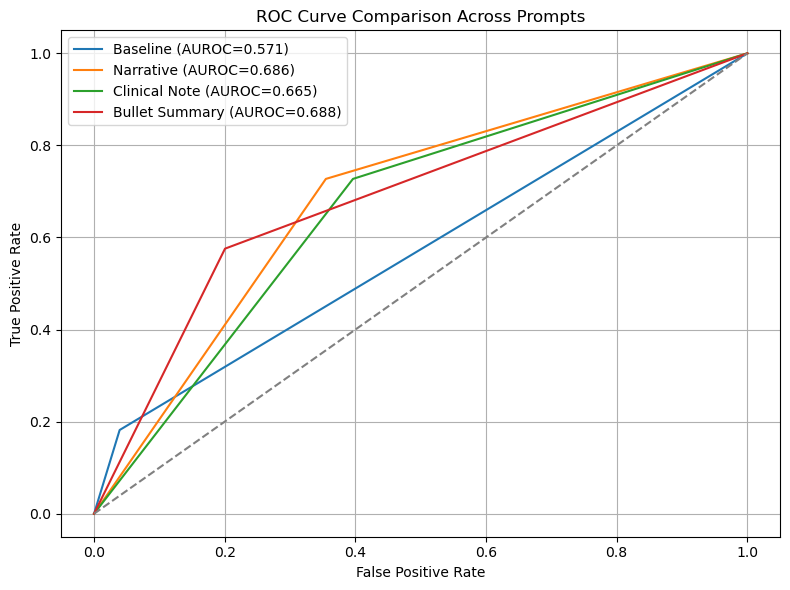

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

models = {
    "Baseline": df["pred_raw"],
    "Narrative": df["pred_narr"],
    "Clinical Note": df["pred_clinical_note"],
    "Bullet Summary": df["pred_bullet"]
}

y_true = df["mortality"]

for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_true, preds)
    plt.plot(fpr, tpr, label=f"{name} (AUROC={roc_auc_score(y_true, preds):.3f})")

plt.plot([0, 1], [0, 1], '--', color='gray')  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Prompts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_comparison.png", dpi=300)
plt.show()


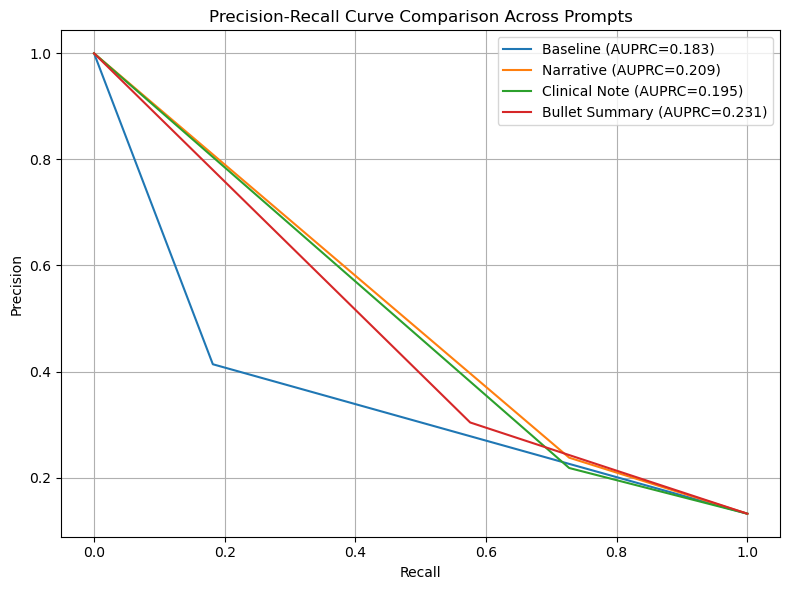

In [25]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))

for name, preds in models.items():
    precision, recall, _ = precision_recall_curve(y_true, preds)
    prc = average_precision_score(y_true, preds)
    plt.plot(recall, precision, label=f"{name} (AUPRC={prc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison Across Prompts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pr_curve_comparison.png", dpi=300)
plt.show()